# Setup Paths

In [3]:
import os
import object_detection


#########################
#define paths and model names, models are taken from tensorflow model zoo
CUSTOM_MODEL_NAME = 'ssd_mobilenet_v2_320x320_trial_6_40000_b4'      # model folder in workspace
#PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map_ds1.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'nt':
            !mkdir {path}
        else:
            print("os.name is not 'nt' (not windows)")





In [ ]:
#Some script which checks what if the configuration above was performed succesfully

VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

# Load Train Model From Checkpoint

In [4]:
#There is a need to have checkpoints in locations given below. They are automatically generated with training script 

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-80')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image
### This part and the next one is for one picture detection 

In [5]:
tf.config.run_functions_eagerly(True)

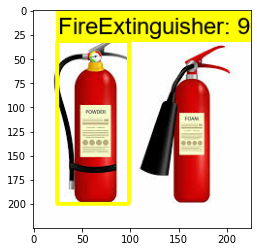

[2] ['FireExtinguisher'] [0.9584969] 0.2740054726600647 0.5156520009040833


In [43]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
treshold = 0.8


category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'fire.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=treshold,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()


########################################################
# Acquiring the data and putting it into JSON for static image (no timestamp)

detected_object_name = []                                  # Creates empty namelist 
category_index_key_list = list(category_index.keys())      # Takes keys (ids) from label map

detected_object_id = detections['detection_classes'][detections['detection_scores']>treshold] + label_id_offset
for object_ids in detected_object_id:
    detected_object_name.append(category_index[category_index_key_list[object_ids - 1]]['name'])
detected_object_probability = detections['detection_scores'][detections['detection_scores']>treshold]
detected_location = detections['detection_boxes'][detections['detection_scores']>treshold]


for i in range(len(detected_object_id)):
    center_x = (detected_location[i][1] + detected_location[i][3])/2
    center_y = (detected_location[i][0] + detected_location[i][2])/2


print(detected_object_id, detected_object_name, detected_object_probability, center_x, center_y)


# Export data to JSON

In [ ]:
import json
 
# function to add to JSON
def write_json(new_data, filename='test_file.json'):
    with open(filename,'r+') as file:
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)
        file.close()

    
with open('test_file.json', 'r+') as test:
    
    object_list = []
    
    for i in range(len(detected_object_id)):
        object_changable = {}
       
        object_changable["iden"] = str(detected_object_id[i])
        object_changable["name"] = str(detected_object_name[i])
        object_changable["probability"] = str(detected_object_probability[i])
        object_changable["center_x"] = str(center_x[i])
        object_changable["center_y"] = str(center_y[i])
        object_list.append(object_changable)
       
    new_data =  {
        "timestamp": "3",
        "objects": 
            
                object_list   
            },
    json.dump(new_data, test, indent = 4)      
# python object to be appended
  
write_json(new_data)

# Configuration JSON for webcam
### Here starts webcam/real time detection

In [45]:
import json
from datetime import datetime

# function to add to JSON
def write_json(new_data, filename):
    
    with open(filename,'w+') as file:            
        json.dump(new_data, file, indent = 4)

def write_to_json(timestamp, detected_object_id, detected_object_name, detected_object_probability, center_x, center_y, json_data_filename, global_json_data_dict):
    
    filename = "acquired_data/%s.json" %json_data_filename
    #with open(filename, 'w+') as json_file:

    object_list = []

    for i in range(len(detected_object_id)):
        object_changable = {}

        object_changable["iden"] = str(detected_object_id[i])
        object_changable["name"] = str(detected_object_name[i])
        object_changable["probability"] = str(detected_object_probability[i])
        object_changable["center_x"] = str(center_x[i])
        object_changable["center_y"] = str(center_y[i])
        object_list.append(object_changable)

    print(object_list)
    new_data =  {
        "timestamp": str(timestamp),
        "objects": [
                object_list   
        ]
    }
    
    global_json_data_dict.append(new_data)
    write_json(global_json_data_dict, filename)

# Real Time Detections from your Webcam

In [52]:
#!pip uninstall opencv-python-headless -y      #tool for problem solving
import cv2
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline


category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
timestamp = 0    #timestamp declaration for json file
json_data_filename = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") #json filename
global_json_data_dict = [{}] #list of directories used for dumping into json

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    # program stop
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
        
    # acquiring data from NN to write them into JSON
    detected_object_name = []                                  # Creates empty namelist 
    category_index_key_list = list(category_index.keys())      # Takes keys (ids) from label map

    detected_object_id = detections['detection_classes'][detections['detection_scores']>.8] + label_id_offset
    for object_ids in detected_object_id:
        detected_object_name.append(category_index[category_index_key_list[object_ids - 1]]['name'])
    detected_object_probability = detections['detection_scores'][detections['detection_scores']>.8]
    detected_location = detections['detection_boxes'][detections['detection_scores']>treshold]

    center_x = []
    center_y = []
    print("before", type(center_x))
    
    for i in range(len(detected_object_id)):
        center_x = [(detected_location[i][1] + detected_location[i][3])/2]
        center_y = [(detected_location[i][0] + detected_location[i][2])/2]
    
    print("after", type(center_x))
    if detected_object_id.size > 0:
        #console log
        print(detected_object_id, detected_object_name, detected_object_probability, center_x, center_y)
        # sending data to JSON
        timestamp += 1
        write_to_json(timestamp, detected_object_id, detected_object_name, detected_object_probability, center_x, center_y, json_data_filename, global_json_data_dict)


before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <class 'list'>
after <class 'list'>
before <cla

KeyboardInterrupt: 

# Preparation model for Linux detection
### From now on it is only exporting and preparing data for others

# Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

print(command)

#!{command}

# Conversion to TFJS


In [ ]:
!pip install tensorflowjs

command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

print(command)

#!{command}

# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS



# Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

print(command)

#!{command}

FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

print(command)

#!{command}
